# Set up the environment

In [1]:
!git clone https://github.com/hnagn2003/Spot-The-Differences
%pip install --upgrade diffusers[torch]
%pip install tokenizers==0.13.2 transformers==4.25.1
%pip install --upgrade diffusers[flax]

Cloning into 'Spot-The-Differences'...
remote: Enumerating objects: 834, done.
remote: Counting objects: 100% (834/834), done.
remote: Compressing objects: 100% (605/605), done.
remote: Total 834 (delta 207), reused 833 (delta 206), pack-reused 0
Receiving objects: 100% (834/834), 14.24 MiB | 24.09 MiB/s, done.
Resolving deltas: 100% (207/207), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 737.4/737.4 KB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.3/215.3 KB 18.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 57.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, htt

In [2]:
%cd Spot-The-Differences/diffusers


/content/Spot-The-Differences/diffusers


In [3]:
from diffusers import DiffusionPipeline
import torch
from torchvision import transforms
from clipseg.models.clipseg import CLIPDensePredT

/usr/local/lib/python3.9/dist-packages/flax/core/frozen_dict.py:169: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(


In [4]:
%cd ..

/content/Spot-The-Differences


# Loading the input

## Image

In [5]:
from torch import autocast
from matplotlib import pyplot as plt
import cv2
import os
import uuid
from PIL import Image, ImageDraw
import random

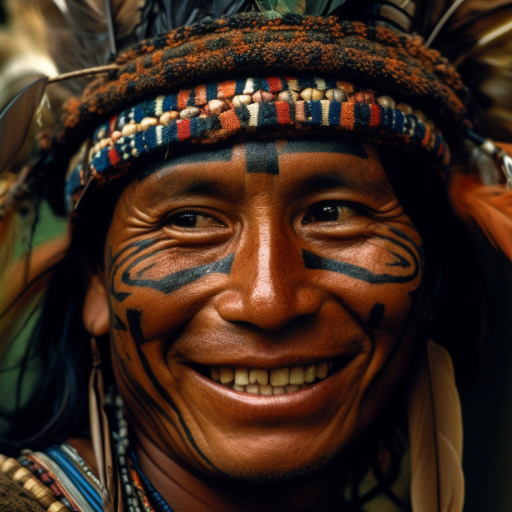

In [6]:
img_path = "input/input_lv3.png"
img_size = 512
img = Image.open(img_path).resize((img_size, img_size))
img.show()

## Mask

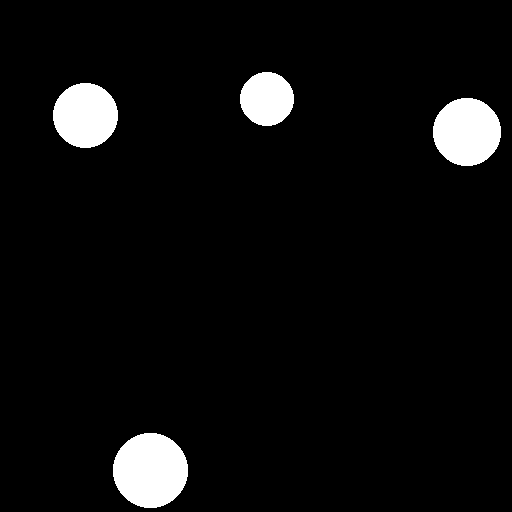

In [7]:
mask = Image.new("RGB", (img_size, img_size))
# random circle in mask has range min_rad, max_rad
min_side = 40
max_side = 80
nums_circles = 4
draw = ImageDraw.Draw(mask)
for i in range (0, nums_circles):
  rand_rad = random.randrange(min_side, max_side)
  x1 = random.randrange(0, img_size-rand_rad)
  y1 = random.randrange(0, img_size-rand_rad)
  draw.ellipse((y1, x1, y1+rand_rad, x1+rand_rad), fill = 'white')
mask.show()
mask.save('mask.png')

# Create differ image

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
pipe = DiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-inpainting",
    revision="fp16", 
    torch_dtype=torch.float16,
).to(device)

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

In [9]:
!pip install git+https://github.com/openai/CLIP.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-uuaim4ww
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-uuaim4ww
  Resolved https://github.com/openai/CLIP.git to commit a9b1bf5920416aaeaec965c25dd9e8f98c864f16
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 KB 3.4 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369398 sha256=c37b6fdc426e8e5797c45589480cbe0e289c7cf667f94ec10257a28ecc9614a4
  Stored in directory: /tmp/pip-ephem-wheel-cache-phg42tkp/wheels/c8/e4/e1/11374c111387672fc2068dfbe0d4b424cb9cdd1b2e184a71b5
Successfully built clip


In [10]:
model = CLIPDensePredT(version='ViT-B/16', reduce_dim=64)
model.eval()
model.load_state_dict(torch.load('diffusers/clipseg/weights/rd64-uni.pth', map_location=torch.device('cuda')), strict=False)

transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
      transforms.Resize((512, 512)),
])

100%|████████████████████████████████████████| 335M/335M [00:02<00:00, 119MiB/s]


In [11]:
from torch import autocast
from matplotlib import pyplot as plt
import cv2
import os
import uuid
from PIL import Image
def predict(image, mask_img, prompt=""):
    init_image = Image.open(image).resize((512, 512))
    mask = Image.open(mask_img).resize((512, 512))
    output = pipe(prompt = prompt, image=init_image, mask_image=mask)
    return output.images[0]
  

In [12]:
prompt=""
output = predict("input/input_lv3.png", "mask.png", prompt)

  0%|          | 0/50 [00:00<?, ?it/s]

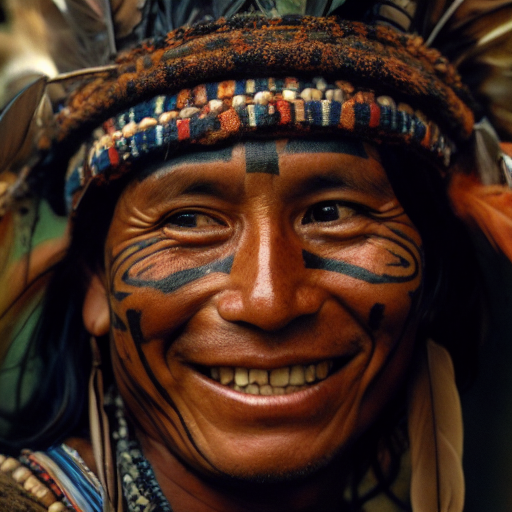

In [13]:
output_path = 'output.png'
output.save(output_path)
output.show()

# Spot the differences between 2 images

In [14]:
from PIL import Image
import cv2
from matplotlib import pyplot as plt
from imutils import contours
from skimage import measure
import numpy as np
import argparse
import imutils

def threshold(tup1, tup2):
    val=0
    if(abs(tup1[0]-tup2[0])>=25):
        val+=1
    if(abs(tup1[1]-tup2[1])>=25):
        val+=1
    if(abs(tup1[2]-tup2[2])>=25):
        val+=1

    if(val>=2):
        return True
    else:
        return False


def main(IMG1, IMG2):
    img1 = Image.open(IMG1)
    img2 = Image.open(IMG2)
    resultImg = img1.copy()
    x, y = min(img1.size[0], img2.size[0]), min(img1.size[1], img2.size[1])
    grid = [[0]*y]*x
    pixImg1 = img1.load()
    pixImg2 = img2.load()
    resultPix = resultImg.load()
    for i in range(x):
        for j in range(y):
            if(threshold(pixImg1[i,j], pixImg2[i,j])):
            # if(pixImg1[i, j]!=pixImg2[i, j]):
                grid[i][j]=1
                resultPix[i,j]=(255, 255, 255)
            else:
                resultPix[i, j]=(0, 0, 0)
    # resultImg.save('result.png')
    finalDetect(IMG1, IMG2, resultImg)


def finalDetect(IMG1, IMG2, res):
    orgImage1 = cv2.imread(IMG1)
    orgImage2 = cv2.imread(IMG2)
    img = np.array(res)
    dst = cv2.fastNlMeansDenoisingColored(img,None,180,180,7,21)
    gray = cv2.cvtColor(dst, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (11, 11), 0)
    
    thresh = cv2.threshold(blurred, 105, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=4)
    labels = measure.label(thresh, connectivity=2, background=0)
    mask = np.zeros(thresh.shape, dtype="uint8")
    for label in np.unique(labels):
        # if this is the background label, ignore it
        if label == 0:
            continue
        # otherwise, construct the label mask and count the
        # number of pixels 
        labelMask = np.zeros(thresh.shape, dtype="uint8")
        labelMask[labels == label] = 255
        numPixels = cv2.countNonZero(labelMask)
        # if the number of pixels in the component is sufficiently
        # large, then add it to our mask of "large blobs"
        if numPixels > 300:
            mask = cv2.add(mask, labelMask)

    cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL,	cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = contours.sort_contours(cnts)[0]
    # loop over the contours
    for (i, c) in enumerate(cnts):
        # draw the bright spot on the image
        (x, y, w, h) = cv2.boundingRect(c)
        ((cX, cY), radius) = cv2.minEnclosingCircle(c)
        cv2.circle(orgImage1, (int(cX), int(cY)), int(radius), (0, 0, 255), 3)
        cv2.circle(orgImage2, (int(cX), int(cY)), int(radius), (0, 0, 255), 3)
        cv2.circle(orgImage1, (int(cX), int(cY)), int(radius), (0, 0, 255), 3)
        cv2.putText(orgImage2, "#{}".format(i + 1), (x, y - 15), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)
        cv2.putText(orgImage1, "#{}".format(i + 1), (x, y - 15), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)
    res = np.concatenate((orgImage1, orgImage2), axis=1)

    invertImg1 = cv2.cvtColor(orgImage1, cv2.COLOR_BGR2RGB)
    invertImg2 = cv2.cvtColor(orgImage2, cv2.COLOR_BGR2RGB)
    plt.subplot(121), plt.imshow(invertImg1)
    plt.subplot(122), plt.imshow(invertImg2)
    cv2.imwrite('result.png', res)
    plt.show()


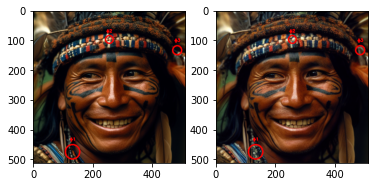

In [15]:
IMG1 = img_path
IMG2 = output_path
main(IMG1, IMG2)